# Relative Elevation Model Grand Canyon

This tutorial is inspired by [this](https://dancoecarto.com/creating-rems-in-qgis-the-idw-method) blog post, [this](https://wadnr.maps.arcgis.com/apps/Cascade/index.html?appid=36b4887370d141fcbb35392f996c82d9) excellent story map, and [this](https://github.com/DahnJ/REM-xarray/blob/master/rem-in-xarray-tutorial.ipynb) notebook.

In [2]:
from pathlib import Path  # Provides classes for working with filesystem paths
import matplotlib.pyplot as plt  # A plotting library for creating static, animated, and interactive visualizations in Python
import numpy as np  # A fundamental package for array computing with Python
import xarray as xr  # An open-source project and Python package that makes working with labeled multi-dimensional arrays simple, efficient, and fun
import xrspatial as xs  # Extends xarray to provide raster analysis functions such as hillshade
from datashader import transfer_functions as tf  # Provides functions for creating visual representations of large datasets
from datashader import utils as ds_utils  # Utility functions for datashader, including image export functionality
from datashader.colors import Greys9, inferno  # Predefined color maps used for visualizing data
from scipy.spatial import KDTree  # Implements a k-dimensional tree for fast spatial searches and nearest-neighbor queries
from shapely import ops  # Provides geometric operations on shapes (geospatial analysis and manipulation)

import py3dep  # Interface to access 3D Elevation Program (3DEP) data from USGS
import pynhd  # Provides tools for working with National Hydrography Dataset (NHD) data


C:\Users\rylim\anaconda3\envs\hyriver\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
import warnings

warnings.filterwarnings("ignore", ".*invalid value encountered in.*")

Relative Elevation Model (REM) detrends a DEM based on the water surface of a stream. It's especially useful for visualization of floodplains. We're going to compute REM for a segment of Carson River and visualize the results using [xarray-spatial](https://xarray-spatial.org) and [datashader](https://datashader.org).

First, let's check out the available DEM resolutions in our area of interest (AOI).

In [31]:
bbox = (-111.90, 36.35,-111.84, 36.40)
dem_res = py3dep.check_3dep_availability(bbox)
dem_res

{'1m': False,
 '3m': False,
 '5m': False,
 '10m': True,
 '30m': True,
 '60m': False,
 'topobathy': False}

We can see that Lidar (1-m), 10-m, and 30-m are available. Obviously, Lidar data gives us the best results, but it can be computationally expensive. So, we're going to set the resolution to 10 m.

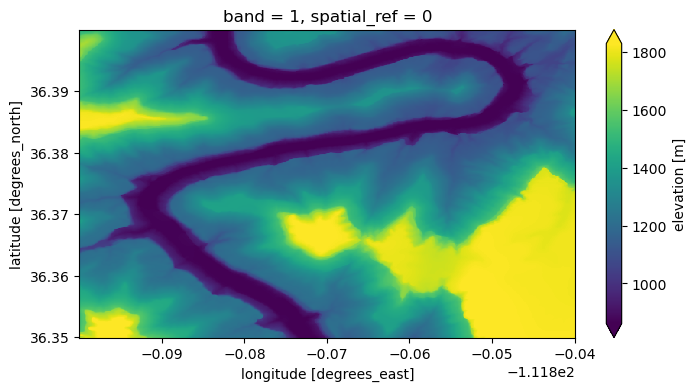

In [32]:
res = 10
dem = py3dep.get_dem(bbox, res)

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
_ = dem.plot(ax=ax, robust=True)

Next, we need to get the river's centerline. For this purpose, first we get the flowlines within our AOI. Then, we remove all the isolated flowlines using the `remove_isolated` flag of `pynhd.prepare_nhdplus` and find the main flowline based on the minimum value of the `levelpathi` attribute.

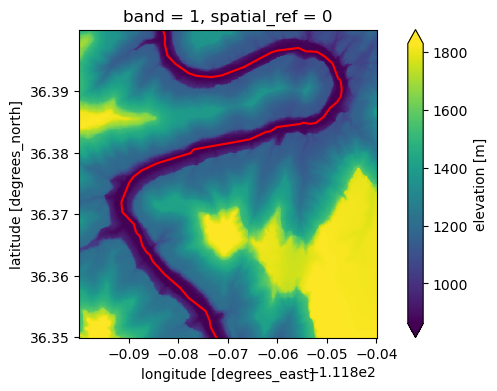

In [33]:
wd = pynhd.WaterData("nhdflowline_network")

flw = wd.bybox(bbox)
flw = pynhd.prepare_nhdplus(flw, 0, 0, 0, remove_isolated=True)
flw = flw[flw.levelpathi == flw.levelpathi.min()].copy()

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
flw.plot(ax=ax, color="r")
_ = dem.plot(ax=ax, robust=True)

Now, we can get the elevation profile along the obtained main flowline with spacing of 10 meters.

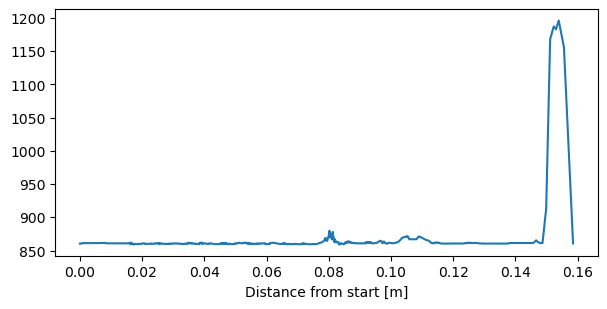

In [34]:
lines = ops.linemerge(flw.geometry.tolist())
riv_dem = py3dep.elevation_profile(lines, 10, crs=flw.crs)
_ = riv_dem.plot(x="distance", figsize=(7, 3.2))

There are several methods for detrending the DEM based on the river's elevation profile. You can check these method in [this](https://www.dnr.wa.gov/publications/ger_presentations_dmt_2016_coe.pdf) poster. Here, we're going to use Inverse Distance Weighting method using `scipy`'s `KDTree` function and setting the number of neighbors to 200.

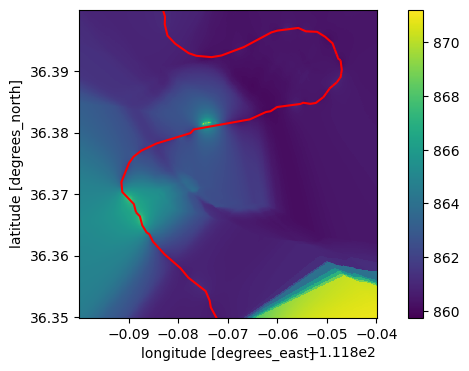

In [35]:
def idw(riv_dem: xr.DataArray, dem: xr.DataArray, n_nb: int) -> xr.DataArray:
    """Interpolate grid DEM from river DEM using Inverse Distance Weighting."""
    riv_coords = np.column_stack((riv_dem.x, riv_dem.y))  # Combine river DEM x and y coordinates into a single array
    kdt = KDTree(riv_coords)  # Create a k-dimensional tree for efficient spatial searches

    dem_grid = np.dstack(np.meshgrid(dem.x, dem.y)).reshape(-1, 2)  # Create a grid of DEM coordinates
    distances, idx = kdt.query(dem_grid, k=n_nb)  # Query the KDTree for nearest neighbors and their distances

    weights = np.reciprocal(distances)  # Compute the inverse of distances to use as weights
    weights = weights / weights.sum(axis=1, keepdims=True)  # Normalize the weights

    interp = weights * riv_dem.to_numpy()[idx]  # Apply weights to river DEM values based on nearest neighbors
    interp = interp.sum(axis=1).reshape((dem.sizes["y"], dem.sizes["x"]))  # Sum the interpolated values and reshape to DEM dimensions
    return xr.DataArray(interp, dims=("y", "x"), coords={"x": dem.x, "y": dem.y})  # Return the interpolated DEM as an xarray DataArray

elevation = idw(riv_dem, dem, 200)  # Perform IDW interpolation to get the elevation grid
rem = dem - elevation  # Calculate the difference between the original DEM and the interpolated elevation

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)  # Create a matplotlib figure and axis
elevation.plot(ax=ax)  # Plot the interpolated elevation on the axis
_ = flw.plot(ax=ax, color="red")  # Plot the flow data on the same axis in red


Let's use datashader to stack DEM, Hillshade and REM for a nice visualization. There are a couple of parameters in this tutorial that can be change for extending it to other regions: Number of neighbors in IDW, DEM resolution, `span` argument of REM's shading operation.

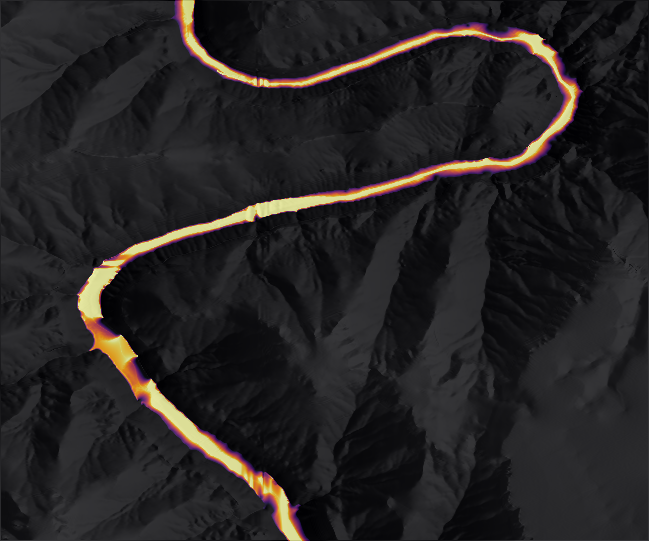

In [36]:
# Ensure the _static directory exists
output_dir = Path("_static")
output_dir.mkdir(parents=True, exist_ok=True)

illuminated = xs.hillshade(dem, angle_altitude=10, azimuth=90)
tf.Image.border = 0
img = tf.stack(
    tf.shade(dem, cmap=Greys9, how="linear"),
    tf.shade(illuminated, cmap=["black", "white"], how="linear", alpha=180),
    tf.shade(rem, cmap=inferno[::-1], span=[0, 7], how="log", alpha=200),
)
ds_utils.export_image(img[::-1], Path("_static", "rem").as_posix())